In [1]:
import os
import json
import warnings
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from collections import defaultdict
from PIL import Image

In [2]:
from data.dataset_maps import class_mapping
class_mapping

{'names': ['background',
  'double_plant',
  'drydown',
  'endrow',
  'nutrient_deficiency',
  'planter_skip',
  'water',
  'waterway',
  'weed_cluster'],
 'int_labs': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'mask_vals': [0, 50, 75, 100, 125, 150, 175, 200, 255]}

In [3]:
overlay_colors = [
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1],  # Blue
    [1, 1, 0],  # Yellow
    [1, 0, 1],  # Magenta
    [0, 1, 1],  # Cyan
    [0.5, 0, 0],  # Dark Red
    [0, 0.5, 0],  # Dark Green
    [0, 0, 0.5]   # Dark Blue
]

In [4]:
def find_image_paths(
    dataset: Literal["images_2021", "images_2024"],
    split: Literal["train", "val", "test"],
    image_id: str
):
    if dataset == "images_2021":
        split = "new_" + split
    
    # rgb image
    rgb_image = f"../data/{dataset}/{split}/images/rgb/{image_id}.jpg"
    if not os.path.exists(rgb_image):
        raise FileNotFoundError(f"Image file not found: {rgb_image}")

    # nir image
    nir_image = f"../data/{dataset}/{split}/images/nir/{image_id}.jpg"
    if not os.path.exists(nir_image):
        raise FileNotFoundError(f"Image file not found: {nir_image}")

    # labels
    true_labels = {}
    for label in [i for i in class_mapping["names"] if i != "background"]:
        label_path = f"../data/{dataset}/{split}/labels/{label}/{image_id}.png"
        if os.path.exists(label_path):
            true_labels[label] = label_path
        else:
            warnings.warn(f"Image file not found: {label_path}")

    return {"rgb_image": rgb_image, "nir_image": nir_image, "true_labels": true_labels}

In [5]:
def read_image(path):
    image = Image.open(path)
    return np.array(image).reshape((*image.size, len(image.getbands())))

def find_images(image_paths):
    d = defaultdict(dict)
    for k, v in image_paths.items():
        if isinstance(v, dict):
            for _k, _v in v.items():
                d[k][_k] = read_image(_v)
        else:
            d[k] = read_image(v)
    return dict(d)

In [6]:
def reformat_labels(labels):
    d = {}
    for i in range(1, 9):
        d[class_mapping["names"][i]] = (labels==i)*255
    return d

In [7]:
def display_image(rgb_image: np.array, nir_image: np.array, true_labels={}, pred_labels={}, show_labels=False, filename=None):

    original_images = []
    true_images = []
    pred_images = []

    # scale input images
    if np.max(rgb_image) <= 1:
        rgb_image = (rgb_image * 255).astype(int)
        nir_image *= np.clip((nir_image * 255).astype(int), 0, 255)

    # overlay setup
    true_overlay_labels = np.zeros(rgb_image.shape)
    true_handles = []
    pred_overlay_labels = np.zeros(rgb_image.shape)
    pred_handles = []

    # reformat labels if labels is np.array with values 0-9
    if isinstance(true_labels, np.ndarray):
        true_labels = reformat_labels(true_labels)
    if isinstance(pred_labels, np.ndarray):
        pred_labels = reformat_labels(pred_labels)
    
    # add true labels and overlays
    if len(true_labels.keys()) > 0:
        for label, image in true_labels.items():
    
            # calculate label percentage
            label_percentage = np.sum(image != 0) / image.size * 100
            label_percentage_string = f"{label} ({label_percentage:.2f}%)"
    
            # add label image
            if show_labels:
                true_images.append((image, "True Label: %s" % label_percentage_string, None))
    
            # add overlay for the label if present in image
            if label_percentage > 0:
                overlay_color = overlay_colors[class_mapping["names"].index(label)]
                true_overlay_labels += 0.7 * image * overlay_color
                true_handles.append(plt.Line2D([], [], color=overlay_color, label=label_percentage_string))

        # add overlay image for true
        true_overlay_image = rgb_image.astype(np.float64) + true_overlay_labels
        true_overlay_image = np.clip(true_overlay_image.astype(int), 0, 255)
        true_images.insert(0, (true_overlay_image, "Overlay Image with True Labels", true_handles))

    # add pred labels and overlays
    if len(pred_labels.keys()) > 0:
        for label, image in pred_labels.items():
    
            # calculate label percentage
            label_percentage = np.sum(image != 0) / image.size * 100
            label_percentage_string = f"{label} ({label_percentage:.2f}%)"
    
            # add label image
            if show_labels:
                pred_images.append((image, "Pred Label: %s" % label_percentage_string, None))
    
            # add overlay for the label if present in image
            if label_percentage > 0:
                overlay_color = overlay_colors[class_mapping["names"].index(label)]
                pred_overlay_labels += 0.7 * image * overlay_color
                pred_handles.append(plt.Line2D([], [], color=overlay_color, label=label_percentage_string))

        # add all overlay for pred
        pred_overlay_image = rgb_image.astype(np.float64) + pred_overlay_labels
        pred_overlay_image = np.clip(pred_overlay_image.astype(int), 0, 255)
        pred_images.insert(0, (pred_overlay_image, "Overlay Image with Pred Labels", pred_handles))

    # add NIR image
    original_images.append((nir_image, "NIR Image", None))
    
    # add RGB image
    original_images.append((rgb_image, "RGB Image", None))

    # append all images
    images_list, images_names, images_handles = zip(*(original_images + true_images + pred_images))
    
    # calculate how many rows and cols figure should have
    n = len(images_list)
    ncols = 4
    nrows = max((n-1) // ncols + 1, 1)
    plt.figure(figsize=(20, nrows*5))

    # iterate through list of images and plot
    for i in range(n):

        # choose plot
        plt.subplot(nrows, ncols, i+1)

        # use cmap="gray" if it is image has 1 image
        if images_list[i].shape[2] == 3:
            plt.imshow(images_list[i])
        elif images_list[i].shape[2] == 1:
            plt.imshow(images_list[i][:,:,0], cmap="gray")

        # set title
        plt.title(images_names[i])

        # add legend to overlay image
        if "Overlay" in images_names[i] and images_handles is not None:
            plt.legend(handles=images_handles[i], loc="upper left")

        # axis off for all images
        plt.axis("off")

    # save figure
    if filename:
        plt.savefig(filename)

{
    "rgb_image": "../data/images_2021/new_val/images/rgb/1AD76MIZN_659-8394-1171-8906.jpg",
    "nir_image": "../data/images_2021/new_val/images/nir/1AD76MIZN_659-8394-1171-8906.jpg",
    "true_labels": {
        "double_plant": "../data/images_2021/new_val/labels/double_plant/1AD76MIZN_659-8394-1171-8906.png",
        "drydown": "../data/images_2021/new_val/labels/drydown/1AD76MIZN_659-8394-1171-8906.png",
        "endrow": "../data/images_2021/new_val/labels/endrow/1AD76MIZN_659-8394-1171-8906.png",
        "nutrient_deficiency": "../data/images_2021/new_val/labels/nutrient_deficiency/1AD76MIZN_659-8394-1171-8906.png",
        "planter_skip": "../data/images_2021/new_val/labels/planter_skip/1AD76MIZN_659-8394-1171-8906.png",
        "water": "../data/images_2021/new_val/labels/water/1AD76MIZN_659-8394-1171-8906.png",
        "waterway": "../data/images_2021/new_val/labels/waterway/1AD76MIZN_659-8394-1171-8906.png",
        "weed_cluster": "../data/images_2021/new_val/labels/weed_cl

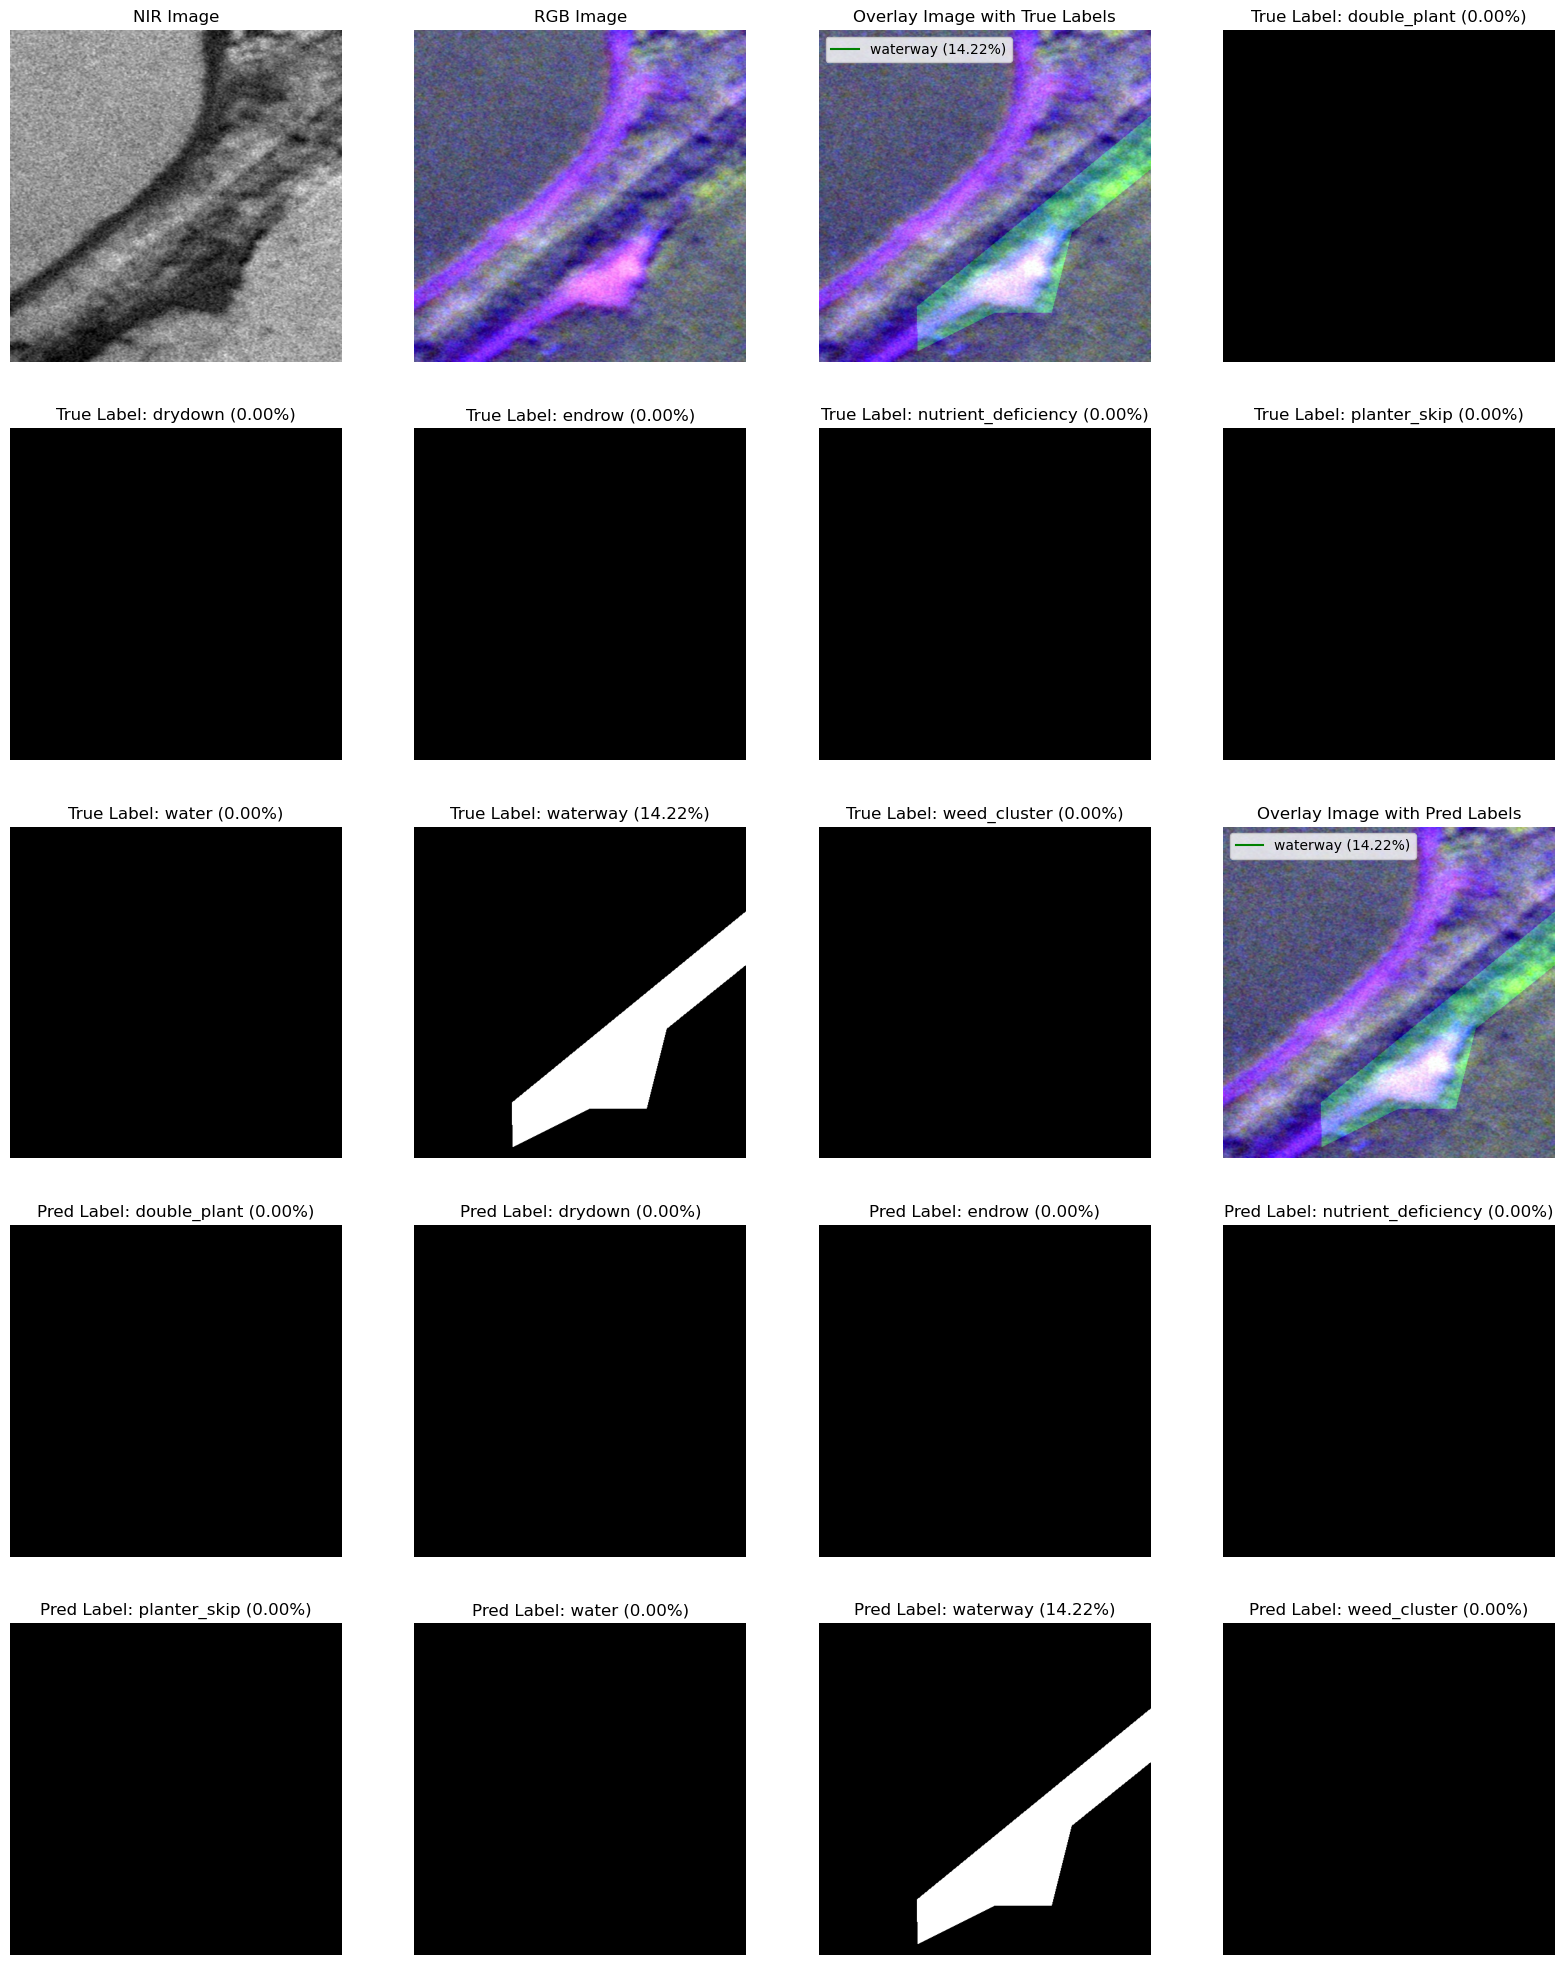

In [8]:
image_paths = find_image_paths("images_2021", "val", "1AD76MIZN_659-8394-1171-8906")
print(json.dumps(image_paths, indent=4))
images = find_images(image_paths)
display_image(
    rgb_image=images["rgb_image"],
    nir_image=images["nir_image"],
    true_labels=images["true_labels"],
    pred_labels=images["true_labels"],
    show_labels=True
)

C:\Users\Francis\AppData\Local\Temp\ipykernel_22424\2158138368.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/double_plant/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_22424\2158138368.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/drydown/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_22424\2158138368.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/endrow/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_22424\2158138368.py:26: UserWarning: Image file not found: ../data/images_2024/train/labels/nutrient_deficiency/1AR7NG3KG_row0_col0.png
  warnings.warn(f"Image file not found: {label_path}")
C:\Users\Francis\AppData\Local\Temp\ipykernel_22424\2158138368.py:26: UserWarning: I

{
    "rgb_image": "../data/images_2024/train/images/rgb/1AR7NG3KG_row0_col0.jpg",
    "nir_image": "../data/images_2024/train/images/nir/1AR7NG3KG_row0_col0.jpg",
    "true_labels": {}
}


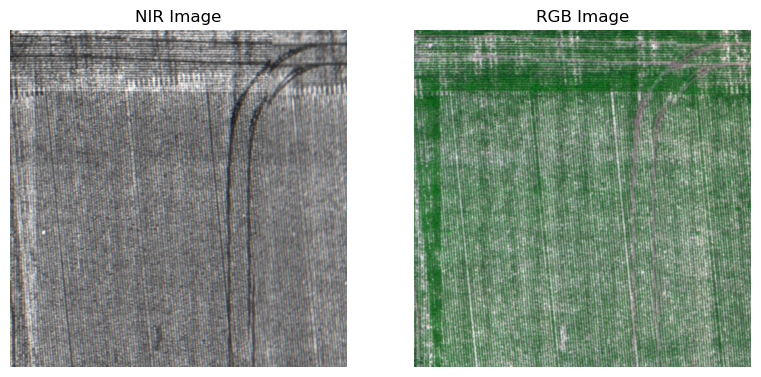

In [9]:
image_paths = find_image_paths("images_2024", "train", "1AR7NG3KG_row0_col0")        
print(json.dumps(image_paths, indent=4))
images = find_images(image_paths)
display_image(images["rgb_image"], images["nir_image"])